# Imports

In [29]:
import copy
import csv
import math
import os
import sys
from datetime import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
import jdc
import time
from statistics import mean
import pickle

# Utility Methods

In [30]:
def calcDurationInHours(starting_time, ending_time):
    return (ending_time - starting_time).total_seconds() / 60 / 60

In [31]:
def time_convert(sec):
    mins = sec // 60
    sec = sec % 60
    hours = mins // 60
    mins = mins % 60
    print("Time Lapsed = {0}:{1}:{2}".format(int(hours),int(mins),sec))

# Objects

In [32]:
class Flights(object):
    legNo = ""
    airport_departure = ""
    date_departure = ""
    hour_departure = ""
    airport_arrival = ""
    date_arrival = ""
    hour_arrival = ""
    pairing_relation = ""
    date_time_arrival = None
    date_time_departure = None
    duration = 0

    # deadhead = False

    def __int__(self):
        self.legNo = self.legNo
        self.airport_departure = self.airport_departure
        self.date_departure = self.date_departure
        self.hour_departure = self.hour_departure
        self.airport_arrival = self.airport_arrival
        self.date_arrival = self.date_arrival
        self.hour_arrival = self.hour_arrival
        # self.pairing_relation = self.pairing_relation

    def setDateTime(self):
        self.date_time_departure = datetime.strptime(str(self.date_departure + ' ' + self.hour_departure), "%Y-%m-%d "
                                                                                                           "%H:%M")
        self.date_time_arrival = datetime.strptime(str(self.date_arrival + ' ' + self.hour_arrival), "%Y-%m-%d %H:%M")
        diff = self.date_time_arrival - self.date_time_departure
        seconds_in_hours = diff.seconds / 60 / 60
        days_in_hours = diff.days * 24
        self.duration = seconds_in_hours + days_in_hours

    def __eq__(self, other):
        return self.legNo == other.legNo

    def __hash__(self):
        return hash(('legNo', self.legNo))

In [33]:
class Duties(object):
    legs: list[Flights] = []
    start_date_time = None
    end_date_time = None
    starting_airport = ""
    ending_airport = ""
    total_flying_time = 0
    total_duration = 0

    def __init__(self, legs: list[Flights]):
        dur = 0
        self.legs = legs
        self.start_date_time = legs[0].date_time_departure
        self.end_date_time = legs[-1].date_time_arrival
        self.starting_airport = legs[0].airport_departure
        self.ending_airport = legs[-1].airport_arrival
        for l3g in legs:
            dur += (l3g.date_time_arrival-l3g.date_time_departure).total_seconds()/60/60
        self.total_flying_time = dur
        self.total_duration = (self.end_date_time - self.start_date_time).total_seconds() / 60 / 60

In [34]:
class Pairings(object):
    id = -1
    legs: list[Flights] = []
    start_date_time = None
    end_date_time = None
    base_airport = ""
    total_duration = 0
    total_flying_time = 0
    cost = 0
    set_flights = {}
    pairing_string = ""

    def __init__(self, fls: list[Flights]):
        self.legs = []

        self.legs = fls
        for l3g in self.legs:
            self.total_flying_time += calcDurationInHours(l3g.date_time_departure, l3g.date_time_arrival)

        self.set_flights = set([l3g.legNo for l3g in self.legs])

        # self.total_flying_time += dty.total_flying_time
        self.start_date_time = self.legs[0].date_time_departure
        self.end_date_time = self.legs[-1].date_time_arrival
        self.base_airport = self.legs[0].airport_departure
        # self.total_flying_time = reduce(mul, [x.total_flying_time for x in duties])
        self.total_duration = calcDurationInHours(self.start_date_time, self.end_date_time)
        disp = ""
        for l3g in self.legs:
            disp += l3g.legNo + " , "
        self.pairing_string = disp[:len(disp) - 3]

    def __eq__(self, other):
        return self.id == other.id

    def __hash__(self):
        return hash(('id', self.id))

In [35]:
class Airport(object):
    name = ""
    is_base = None

    def __init__(self):
        self.name = self.name
        self.is_base = self.is_base

In [36]:
class PairingAlt(object):
    pairing_name = ""
    base = ""
    legs = {}
    start_date = ""
    start_time = ""
    end_date = ""
    end_time = ""
    total_flying_time = ""
    total_duration = 0

    def __int__(self):
        self.pairing_name = self.pairing_name
        self.base = self.base
        self.legs = self.legs
        self.start_date = self.start_date
        self.start_time = self.start_time
        self.end_date = self.end_date
        self.end_time = self.end_time
        self.total_flying_time = self.total_flying_time
        self.total_duration = self.total_duration

In [37]:
class Solution(object):
    id = ""
    solution_pairings = []
    solution_cost = 0
    deadheads = 0
    gen_time = 0
    solution_encoding = []

    def __init__(self):
        self.id = -1
        self.solution_pairings = []
        self.solution_cost = 0
        self.deadheads = 0
        self.gen_time = 0
        self.solution_encoding = []

# File Reading

In [38]:
flights = {}
tempFlights = []
for day in range(31):
    path = os.getcwd() + '\instance1\day_' + str(day + 1) + '.csv'
    first = True
    with open(path) as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
            if not row:
                continue
            elif first:
                first = False
                continue
            elif len(row) <= 6:
                continue
            else:
                f = Flights()
                f.legNo = row[0].strip()
                f.airport_departure = row[1].strip()
                f.date_departure = row[2].strip()
                f.hour_departure = row[3].strip()
                f.airport_arrival = row[4].strip()
                f.date_arrival = row[5].strip()
                f.hour_arrival = row[6].strip()
                key = str(f.legNo.strip())
                # covered[key] = (False, 0)
                f.setDateTime()
                tempFlights.append(f)

tempFlights.sort(key=lambda x: x.date_time_arrival, reverse=False)
for flight in tempFlights:
    flights[flight.legNo] = flight

In [39]:
genesisPair = []
path = os.getcwd() + '\instance1\initialSolution.in'
with open(path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for row in reader:
        # print(row)
        # print('----------------------------')
        if not row:
            continue
        elif len(row[0]) <= 15:
            #  Do not do anything if the row is does not contain pairing information
            continue
        else:
            P = PairingAlt()
            main_index = row[0].find(': Base')  # Setting the index as a limit on which to extract string of row
            P.pairing_name = row[0][0: main_index - 1].strip()
            # Setting the index as a limit on which to extract string of row
            if 'TDH' in row[0]:
                main_index = row[0].find(': TDH')
            else:
                main_index = row[0].find(': LEG')
            sub_index = row[0].find('BASE')  # Getting starting index from which to extract
            P.base = row[0][sub_index:main_index - 1].strip()
            num = len(row[1:])

            holder = [row[0][main_index + 1:].strip()]
            for n in range(num):
                if ';' in row[n + 1]:
                    holder.append(row[n + 1][0:-1].strip())
                else:
                    holder.append(row[n + 1].strip())

            P.legs = holder
            key = str(P.pairing_name.strip())  # Key prefixed with instance number

            #  Setting Key for flight search
            firstLeg = str(P.legs[0])
            lastLeg = str(P.legs[-1])

            #  Removing TDH when searching for a Key
            if 'TDH_' in firstLeg:
                firstLeg = firstLeg.replace("TDH_", "")
            P.start_date = flights[firstLeg].date_departure
            P.start_time = flights[firstLeg].hour_departure
            if 'TDH_' in lastLeg:
                lastLeg = lastLeg.replace("TDH_", "")
            P.end_date = flights[lastLeg].date_arrival
            P.end_time = flights[lastLeg].hour_arrival

            # Calculating the credited flying time for a pairing
            total_flying_time = 0
            for k, p in enumerate(P.legs):
                if 'TDH' in p:
                    p = p.replace("TDH_", "")
                    P.legs[k] = p.replace("TDH_", "")
                total_flying_time += flights[p].duration
            P.total_flying_time = total_flying_time
            P.total_duration = calcDurationInHours(flights[P.legs[0]].date_time_departure, flights[P.legs[-1]].date_time_arrival)

            genesisPair.append(P)

In [40]:
airports = {}
path = os.getcwd() + '\instance1\listOfBases.csv'
with open(path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    first = True
    for row in reader:
        if not first:
            a = Airport()
            a.name = row[0].strip()
            if int(row[1]):
                a.is_base = True
                # bases[a.name] = a
            else:
                a.is_base = False
            airports[a.name] = a
        else:
            first = False

# Graph

In [41]:
g = nx.DiGraph()

In [42]:
for airport in airports.keys():
    g.add_node(airport)

In [43]:
for flight in flights.items():
    day = int(flight[1].legNo[4:6])
    if not g.has_edge(flight[1].airport_departure, flight[1].airport_arrival):
        g.add_edge(flight[1].airport_departure, flight[1].airport_arrival, flight_list = {f"{flight[1].legNo}": (flight[1], False, day)}, weight=flight[1].duration)
    else:
        orig = g[flight[1].airport_departure][flight[1].airport_arrival]["flight_list"]
        orig[flight[1].legNo] = (flight[1], False, day)
        new_attr = {(flight[1].airport_departure, flight[1].airport_arrival) : {"flight_list" : orig}}
        nx.set_edge_attributes(g, new_attr)

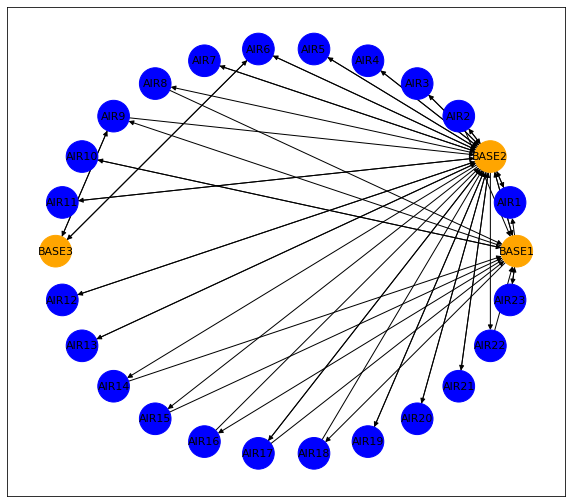

In [44]:
pos = nx.circular_layout(g)
c_m = {}
for item in airports.items():
    if item[1].is_base:
        c_m[item[1].name] = "orange"
    else:
        c_m[item[1].name] = "blue"
colors = [c_m.get(node) for node in g.nodes()]
plt.figure(figsize= (10,9))
nx.draw_networkx(g, pos, node_size=1000, font_size=11, node_color=colors)

# Covering Flights Code

In [45]:
def init_cover_list() -> dict:
    cvrd = {}
    for fl in flights:
        cvrd[fl] = (False, 0)
    return cvrd

In [46]:
def getNonCoveredFlights(cvrd) -> list[Flights]:
    not_covered_flights = []
    for cov in cvrd.items():
        if not cov[1][0]:
            # print(cov)
            not_covered_flights.append(cov)
    return not_covered_flights

In [47]:
def checkCovered(cvd) -> bool:
    covrd = True
    # counter = 0
    for it in cvd.items():
        if not it[1][1]:
            covrd = False
            break
            # counter+=1
    # print(counter)
    return covrd

# Pairing Generation

In [48]:
def validPairing(curr: list[Flights]) -> tuple[int, int]:
    kp = 1
    ct = 1
    # length_curr = len(curr)
    tempP = Pairings(curr)
    if tempP.pairing_string == "LEG_24_29 , LEG_24_4 , LEG_24_5 , LEG_25_8 , LEG_25_7 , LEG_25_9":
        print()

    if list_of_non_cvrd is not None:
        # set_of_non_covered = set(list_of_non_cvrd)
        continueSearching = False
        for fl in list_of_non_cvrd:
            if calcDurationInHours(curr[0].date_time_departure, flights[fl].date_time_arrival) < 72:
                continueSearching = True
        if not continueSearching:
            return 0,0


    if tempP.total_flying_time / tempP.total_duration * 100 < allowedRatio:
        kp = 0

    if tempP.base_airport != curr[-1].airport_arrival:
        kp = 0

    if tempP.total_duration > 72:
        return 0, 0

    dateTimer = 0
    flightTimer = 0

    reversedCurr = [curr[j] for j in range(len(curr) - 1, -1, -1)]
    for j, fl in enumerate(reversedCurr):
        flightTimer += fl.duration
        dateTimer += fl.duration

        if j != 0:
            flight_diff = calcDurationInHours(fl.date_time_arrival, reversedCurr[j-1].date_time_departure)
            if flight_diff < 0.25:
                return 0,0


            if dateTimer + flight_diff > 14:
                if flight_diff < 10:
                    return 0, 0
                else:
                    break
            else:
                dateTimer += flight_diff

        if flightTimer > 8:
            return 0,0

    return kp, ct

In [49]:
 # for j, fl in enumerate(curr):
 #    flightTimer += fl.duration
 #    dateTimer += fl.duration
 #
 #    if flightTimer > 8:
 #        return 0,0
 #
 #    if j + 1 != len(curr):
 #        flight_diff = calcDurationInHours(fl.date_time_arrival, curr[j+1].date_time_departure)
 #        if flight_diff < 0.25:
 #            return 0,0
 #
 #
 #        if dateTimer + flight_diff > 14:
 #            if flight_diff < 10:
 #                return 0, 0
 #            else:
 #                dateTimer = 0
 #                flightTimer = 0
 #        else:
 #            dateTimer += flight_diff

In [50]:
def searchPairings(current: list[Flights], pairings: list[Pairings]) -> list[Pairings]:
    keep, cont = validPairing(current)
    if keep:
        pair = Pairings(copy.deepcopy(current))
        pairings.append(pair)
    if cont:
        first_leg = current[0]
        last_leg = current[-1]
        for ed in g.out_edges(last_leg.airport_arrival):
            for fl_ed in g[ed[0]][ed[1]]["flight_list"].items():
                f_inner : Flights = fl_ed[1][0]
                if calcDurationInHours(first_leg.date_time_departure, f_inner.date_time_arrival) > 72:
                    break
                if calcDurationInHours(last_leg.date_time_arrival, f_inner.date_time_departure) >= 0.25:
                    current.append(f_inner)
                    pairings = searchPairings(current, pairings)
                    current.remove(f_inner)
    return pairings

In [51]:
def calcPairingCost(p_toCalc: Pairings) -> float:
    return math.floor(1000*p_toCalc.total_duration/p_toCalc.total_flying_time)

In [52]:
all_pairings = []
list_of_non_cvrd = None
for airport in airports.items():
    air = airport[1]
    air: Airport
    if air.is_base:
        print("Base: ", air.name, sep="")
        for edge in g.out_edges(air.name):
            allowedRatio = 25
            print("Generating pairings for ", edge, sep="")
            beforeNew = len(all_pairings)
            for flight in g[edge[0]][edge[1]]["flight_list"].items():
                f : Flights = flight[1][0]
                # print(f.legNo)

                new_pairings = searchPairings([f], [])
                all_pairings.extend(new_pairings)
            print("Pairings Generated = ", len(all_pairings) - beforeNew, sep="")
        print("---------------")

Base: BASE1
Generating pairings for ('BASE1', 'AIR1')
Pairings Generated = 1733
Generating pairings for ('BASE1', 'AIR9')
Pairings Generated = 4371
Generating pairings for ('BASE1', 'AIR10')
Pairings Generated = 232
Generating pairings for ('BASE1', 'AIR16')
Pairings Generated = 487
Generating pairings for ('BASE1', 'BASE2')
Pairings Generated = 561
Generating pairings for ('BASE1', 'AIR18')
Pairings Generated = 0
Generating pairings for ('BASE1', 'AIR23')
Pairings Generated = 64
---------------
Base: BASE2
Generating pairings for ('BASE2', 'AIR12')
Pairings Generated = 21914
Generating pairings for ('BASE2', 'AIR6')
Pairings Generated = 29560
Generating pairings for ('BASE2', 'AIR3')
Pairings Generated = 25101
Generating pairings for ('BASE2', 'AIR2')
Pairings Generated = 16610
Generating pairings for ('BASE2', 'AIR5')

Pairings Generated = 9160
Generating pairings for ('BASE2', 'AIR4')
Pairings Generated = 22866
Generating pairings for ('BASE2', 'AIR7')
Pairings Generated = 4864
Gene

In [53]:
covered = init_cover_list()
for pairing in all_pairings:
    pairing : Pairings
    for leg in pairing.legs:
        covered[leg.legNo] = (True, covered[leg.legNo][1]+1)

non_covrd = getNonCoveredFlights(covered)
if len(non_covrd) != 0:
    print(non_covrd)
    list_of_non_cvrd = [e[0] for e in non_covrd]
    allowedRatio = 0
    for airport in airports.items():
        air = airport[1]
        air: Airport
        if air.is_base:
            print(air.name)
            for edge in g.out_edges(air.name):
                print(edge)
                beforeNew = len(all_pairings)
                for flight in g[edge[0]][edge[1]]["flight_list"].items():
                    delete = True
                    f : Flights = flight[1][0]

                    new_pairings = searchPairings([f], [])
                    temp_new_pairings = new_pairings[:]
                    for p in new_pairings:
                        for leg in p.legs:
                            if leg.legNo in list_of_non_cvrd:
                                delete = False
                        if delete:
                            temp_new_pairings.remove(p)
                    all_pairings.extend(temp_new_pairings)
                print("Pairings Generated = ", len(all_pairings) - beforeNew, sep="")
                print("--")
    for pairing in all_pairings:
        pairing : Pairings
        for leg in pairing.legs:
            covered[leg.legNo] = (True, covered[leg.legNo][1]+1)
    non_covrd = getNonCoveredFlights(covered)

if len(non_covrd) != 0:
    print("Parameters are impossible")

[('LEG_27_0', (False, 0)), ('LEG_27_12', (False, 0))]
BASE1
('BASE1', 'AIR1')
Pairings Generated = 0
--
('BASE1', 'AIR9')
Pairings Generated = 0
--
('BASE1', 'AIR10')
Pairings Generated = 0
--
('BASE1', 'AIR16')
Pairings Generated = 0
--
('BASE1', 'BASE2')
Pairings Generated = 0
--
('BASE1', 'AIR18')
Pairings Generated = 62
--
('BASE1', 'AIR23')
Pairings Generated = 0
--
BASE2
('BASE2', 'AIR12')
Pairings Generated = 0
--
('BASE2', 'AIR6')
Pairings Generated = 0
--
('BASE2', 'AIR3')
Pairings Generated = 4164
--
('BASE2', 'AIR2')
Pairings Generated = 6910
--
('BASE2', 'AIR5')

Pairings Generated = 2035
--
('BASE2', 'AIR4')
Pairings Generated = 3558
--
('BASE2', 'AIR7')
Pairings Generated = 0
--
('BASE2', 'AIR11')
Pairings Generated = 1765
--
('BASE2', 'AIR8')
Pairings Generated = 37
--
('BASE2', 'AIR13')
Pairings Generated = 1054
--
('BASE2', 'AIR14')
Pairings Generated = 0
--
('BASE2', 'AIR15')
Pairings Generated = 0
--
('BASE2', 'AIR17')
Pairings Generated = 1626
--
('BASE2', 'AIR1')
P

In [54]:
# backup = all_pairings[:]
seen_pairings = set()
temp_new_pairings = all_pairings[:]
all_pairings = []

for obj in temp_new_pairings:
    if obj.pairing_string not in seen_pairings:
        all_pairings.append(obj)
        seen_pairings.add(obj.pairing_string)


print("Total Pairings Generated: ", len(all_pairings), sep="")

Total Pairings Generated: 243240


In [55]:
for p in all_pairings:
    p.cost = calcPairingCost(p)
all_pairings.sort(key=lambda xt: xt.cost, reverse=False)

final = 0
for i, p in enumerate(all_pairings):
    p.id = i
    final = i

flight_pairings : {str:list[Pairings]} = {}
backup_pairings = all_pairings[:]

for p in backup_pairings:
    for f in p.legs:
        if f.legNo in flight_pairings:
            flight_pairings[f.legNo].append(p)
        else:
            flight_pairings[f.legNo] = [p]

for plst in flight_pairings.items():
    flight_pairings[plst[0]] = set(plst[1])

In [56]:
len(all_pairings)

243240

In [57]:
# avg = mean([item.cost for item in backup_pairings])
# counter = 0
# backup_pairings.sort(key=lambda x: x.cost, reverse=True)
#
# for i, p in enumerate(backup_pairings):
#     rem = True
#     count = min([len(flight_pairings[f.legNo]) for f in p.legs])
#     if count < 100:
#         rem = False
#
#     if rem:
#         counter += 1
#         del backup_pairings[i]
#         for f in p.legs:
#             flight_pairings[f.legNo].remove(p)
#         # print(counter)

In [58]:
# len(backup_pairings)
#
# temp_backup_pairings = backup_pairings[:]


In [59]:
# backup_pairings = all_pairings[:]

In [60]:
# all_pairings = temp_backup_pairings[:]

In [61]:
# all_pairings.sort(key=lambda xt: xt.cost, reverse=False)
#
# final = 0
# for i, p in enumerate(all_pairings):
#     p.id = i
#     final = i

In [62]:
msg = []
pop_dict = {}
for i, pairing in enumerate(all_pairings):
    pairing: Pairings
    display = ""
    for leg in pairing.legs:
        display += leg.legNo + " , "
    msg.append("".join(["Pairing ", str(i + 1), ": ", display[:len(display) - 2]]))
    msg.append("".join(["Total Time:", str(pairing.total_duration)]))
    msg.append("".join(["Total Flying Time:", str(pairing.total_flying_time)]))
    msg.append("--------------")

with open('pairings.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(msg))

# print("Total Pairings:", len(all_pairings))

In [63]:
with open('pairingsObject.txt', 'wb') as pairings_file:

    # Step 3
    pickle.dump(all_pairings, pairings_file)

In [64]:
with open('pairingsObject.txt', 'rb') as pairings_file:
    backup_pairings = pickle.load(pairings_file)

# Initial Population Code

In [65]:
def checkSimilarity(cvd, t_pairing: Pairings) -> int:
    total_legs = len(t_pairing.legs)
    present_legs = 0
    for Leg in t_pairing.legs:
        if cvd[Leg.legNo][0]:
            present_legs += 1
    return present_legs/total_legs * 100

In [66]:
def returnFeasibleSolution(curr_sol: Solution):
    if len(curr_sol.solution_pairings) == 0:
        curr_sol.solution_pairings = convertFromBinaryToPairings(to_convert=curr_sol.solution_encoding)
    cov = init_cover_list()
    for pair in curr_sol.solution_pairings:
        for fl in pair.legs:
            cov[fl.legNo] = (True, cov[fl.legNo][1]+1)
    non_covered = getNonCoveredFlights(cov)
    list_of_non_covered =[e[0] for e in non_covered]
    set_of_non_covered = set(list_of_non_covered)


    for fl in list_of_non_covered:
        if fl in set_of_non_covered:
            candidates = []
            temp_pairings = list(flight_pairings[fl])
            for pair in temp_pairings:
                potential_cover = len(set_of_non_covered.intersection(pair.set_flights))
                candidates.append((pair, 1.0*pair.cost/potential_cover))
            candidates.sort(key=lambda x: x[1], reverse=False)
            curr_sol.solution_pairings.append(candidates[0][0])
            if len(curr_sol.solution_encoding)!= 0:
                curr_sol.solution_encoding[candidates[0][0].id] = 1
            for l3g in candidates[0][0].legs:
                if l3g.legNo in set_of_non_covered:
                    set_of_non_covered.remove(l3g.legNo)

    curr_sol = clearUnusedPairings(curr_sol)
    return curr_sol

In [67]:
def clearUnusedPairings(curr_sol) -> Solution:
    cov = init_cover_list()
    curr_sol.solution_pairings.sort(key=lambda xt: xt.cost, reverse=False)
    for j, pair in enumerate(curr_sol.solution_pairings):
        remove = True
        for fl in pair.legs:
            if cov[fl.legNo][0] is False:
                remove = False
                cov[fl.legNo] = (True, None)
        if remove:
            curr_sol.solution_pairings.remove(pair)
            if len(curr_sol.solution_encoding)!= 0:
                curr_sol.solution_encoding[pair.id] = 0
    return curr_sol

In [68]:
def find_random_solution():
    solution = Solution()
    covered_flights = init_cover_list()
    temp_pairings = all_pairings[:]
    while len(temp_pairings)!= 0:
        index = random.randint(0, len(temp_pairings)-1)
        if len(solution.solution_pairings) == 0:
            solution.solution_pairings.append(temp_pairings[index])
            for Leg in temp_pairings[index].legs:
                covered_flights[Leg.legNo] = (True, covered_flights[Leg.legNo][1]+1)
        else:
            sim = checkSimilarity(covered_flights, temp_pairings[index])
            if sim == 0:
                solution.solution_pairings.append(temp_pairings[index])
                for Leg in temp_pairings[index].legs:
                    covered_flights[Leg.legNo] = (True, covered_flights[Leg.legNo][1]+1)
        del temp_pairings[index]
    return returnFeasibleSolution(solution)

In [69]:
def calcDeadheadsFromCover(cov):
    j = 0
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [70]:
def calcDeadheadsAlt(sol):
    j = 0
    cov = init_cover_list()
    for pr in sol:
        for Leg in pr.legs:
            cov[Leg] = (True, cov[Leg][1]+1)
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [71]:
def calcDeadheadsFromSolution(sol):
    j = 0
    cov = init_cover_list()
    for pr in sol:
        for Leg in pr.legs:
            cov[Leg.legNo] = (True, cov[Leg.legNo][1]+1)
    for it in cov.items():
        # print(item)
        if it[1][1] > 1:
            j+=(it[1][1]-1)
    return j

In [72]:
def calcSolutionCost(pairs: list[Pairings], deadheads:int) -> float:
    c = 0
    for pr in pairs:
        c+=calcPairingCost(pr)
    c+= deadheads*1000
    return c

In [73]:
# covered_list = []

pre_population = []

for i in range(100):
    print("Solution", i+1, sep=" ", end= "\n")
    s = find_random_solution()
    s.id = i
    s.deadheads = calcDeadheadsFromSolution(s.solution_pairings)
    s.solution_cost = calcSolutionCost(s.solution_pairings, s.deadheads)
    print("Deadheads: ", s.deadheads, sep="")
    print("Solution Length: ", len(s.solution_pairings), sep="")
    print("Solution Cost: ", s.solution_cost, sep="")
    pre_population.append(s)

Solution 1
Deadheads: 416
Solution Length: 197
Solution Cost: 1098632
Solution 2
Deadheads: 392
Solution Length: 197
Solution Cost: 1023944
Solution 3
Deadheads: 402
Solution Length: 202
Solution Cost: 1056964
Solution 4
Deadheads: 417
Solution Length: 205
Solution Cost: 1096091
Solution 5
Deadheads: 421
Solution Length: 210
Solution Cost: 1100467
Solution 6
Deadheads: 381
Solution Length: 205
Solution Cost: 1047201
Solution 7
Deadheads: 347
Solution Length: 194
Solution Cost: 989048
Solution 8
Deadheads: 363
Solution Length: 198
Solution Cost: 999952
Solution 9
Deadheads: 358
Solution Length: 196
Solution Cost: 988616
Solution 10
Deadheads: 389
Solution Length: 199
Solution Cost: 1036940
Solution 11
Deadheads: 394
Solution Length: 195
Solution Cost: 1017937
Solution 12
Deadheads: 376
Solution Length: 196
Solution Cost: 1023033
Solution 13
Deadheads: 410
Solution Length: 212
Solution Cost: 1106398
Solution 14
Deadheads: 406
Solution Length: 208
Solution Cost: 1095242
Solution 15
Deadhe

In [74]:
# GA generate 100 solutions randomly -- done
# Genesis solution has to be one of the starting 100 -- can be done
# Shall always use the best solutions for the following (The best 10 must ALWAYS go in)
# have a way of determining if a solution is valid or not. //Genetic repair to fix it
#   crossover operator - from the solution ex. you get one pairing from one and another and you star picking from one to another and you do it until a certain point you must repair it.
# Genetic operators are SUPER important
# fitness func use cost
# take the init population and create another 500 from crossover, order them by cost, create another 100 and use prob tournament
# take another population

#VIMP -- Every solution has to be a unique code - to track if a solution makes it from solution to solution and how it was born and how it died. Some will survive but won't be the best and we must know this. -- solution object created

# how many at each generation are new, average lifespan - lower the better as you are getting better ones.

In [75]:
genesisPairActual = Solution()
update = False
for P in genesisPair:
    match_length = len(P.legs)
    find = False
    for item in flight_pairings[P.legs[0]]:
        if len(set(P.legs).intersection(item.set_flights)) == match_length:
            find = True
            genesisPairActual.solution_pairings.append(item)
    if not find:
        print("".join([leg + " , " for leg in P.legs]))
        ls = [flights[leg] for leg in P.legs]
        all_pairings.append(Pairings(ls))
        genesisPairActual.solution_pairings.append(all_pairings[-1])
        update = True

if update:
    for p in all_pairings:
        p.cost = calcPairingCost(p)
    all_pairings.sort(key=lambda xt: xt.cost, reverse=False)

    final = 0
    for i, p in enumerate(all_pairings):
        p.id = i
        final = i

    flight_pairings = {}
    for p in all_pairings:
        for f in p.legs:
            if f.legNo in flight_pairings:
                flight_pairings[f.legNo].append(p)
            else:
                flight_pairings[f.legNo] = [p]


LEG_29_1 , LEG_30_11 , LEG_30_0 , LEG_30_22 , LEG_30_23 , LEG_30_4 , 
LEG_01_21 , LEG_01_4 , LEG_01_32 , LEG_02_10 , LEG_02_11 , LEG_02_19 , LEG_02_23 , LEG_03_22 , LEG_03_14 , LEG_04_35 , 
LEG_04_18 , LEG_04_15 , LEG_04_9 , LEG_05_28 , LEG_05_26 , LEG_05_25 , LEG_06_28 , LEG_06_2 , LEG_06_3 , LEG_06_31 , LEG_06_30 , LEG_07_10 , LEG_07_11 , LEG_07_19 , 
LEG_17_27 , LEG_17_28 , LEG_17_23 , LEG_17_18 , LEG_17_19 , LEG_18_14 , LEG_18_13 , LEG_18_22 , LEG_19_16 , LEG_19_11 , LEG_19_22 , LEG_19_13 , LEG_20_2 , LEG_20_14 , 
LEG_15_1 , LEG_15_32 , LEG_15_31 , LEG_16_11 , LEG_16_12 , LEG_16_21 , LEG_16_25 , LEG_17_24 , LEG_17_29 , LEG_17_4 , 
LEG_07_29 , LEG_07_24 , LEG_08_25 , LEG_08_27 , LEG_08_21 , LEG_08_4 , LEG_08_5 , LEG_09_7 , LEG_09_6 , LEG_09_8 , 
LEG_07_3 , LEG_07_34 , LEG_07_33 , LEG_08_10 , LEG_08_11 , LEG_08_19 , LEG_09_18 , LEG_09_15 , LEG_09_9 , LEG_10_32 , LEG_10_30 , LEG_10_28 , 
LEG_13_20 , LEG_14_23 , LEG_14_30 , LEG_14_25 , LEG_15_27 , LEG_15_28 , LEG_15_23 , LEG_15_18 , LE

## Genetic Algorithm

In [76]:
def convertFromPopulationToBinary(pop):
    blank_gene = [0 for _ in all_pairings]

    for sol in pop:
        sol.solution_encoding = blank_gene[:]
        for pair in sol.solution_pairings:
            #Just in case assignment went wrong
            if not hasattr(pair, "id"):
                hold = None
                found = False
                for searcher in all_pairings:
                    if pair.end_date_time == searcher.end_date_time and searcher.cost == pair.cost and searcher.start_date_time == pair.start_date_time:
                        if not found:
                            hold = searcher
                            found = True
                        else:
                            found= False
                            break
                if found:
                    sol.solution_encoding[hold.id] = 1
                else:
                    print("Fatal error")
            else:
                sol.solution_encoding[pair.id] = 1

In [77]:
def convertFromBinaryToPairings(to_convert):
    temp_sol = []
    for j, binary in enumerate(to_convert):
        if binary == 1:
            temp_sol.append(all_pairings[j])
    return temp_sol

In [78]:
class GeneticAlgorithm:
    min_generations = 0
    generation_num = 0
    mutation_rate = 0
    initial_GA_population = 100
    population: list[Solution] = []
    pop_copy: list[Solution] = []
    threshold = -sys.maxsize
    crossover_rate = 0
    max_generations = 0

    def __init__(self, min_generations, mutation_rate, initial_population, threshold, crossover_rate, max_generations):
        self.min_generations = min_generations
        self.mutation_rate = mutation_rate
        self.population = initial_population[:]
        self.pop_copy = initial_population[:]
        self.threshold = threshold
        self.crossover_rate = crossover_rate
        self.max_generations = max_generations

In [79]:
    %%add_to GeneticAlgorithm
    def sort_by_cost(self):
        self.population.sort(key=lambda x: x.solution_cost, reverse=False)
        self.pop_copy.sort(key=lambda x: x.solution_cost, reverse=False)


In [80]:
def mutate(child : Solution):
    # for j, binary in enumerate(child.solution_encoding):
    #     befBin = binary
    #     reciprocal = 1/len(child.solution_encoding)
    #     if binary == 0:
    #         child.solution_encoding[j] = int(random.choices([0,1], weights=[1-reciprocal, reciprocal], k=1)[0])
    #     else:
    #         child.solution_encoding[j] = int(random.choices([1,0], weights=[1-reciprocal, reciprocal], k=1)[0])
    #     # if befBin != child.solution_encoding[j]:
    #     #     print("Mutate!")
    reciprocal = 1/len(child.solution_encoding)
    mutations = (random.choices([0,1], [1-reciprocal, reciprocal], k=len(child.solution_encoding))).count(1)
    for j in range(mutations):
        indx = random.randint(0, len(child.solution_encoding)-1)
        binary = child.solution_encoding[indx]
        if binary:
            child.solution_encoding[indx] = 0
        else:
            child.solution_encoding[indx] = 1
    return child

In [81]:
def roulette_wheel_selection(GA) -> Solution:
    #reproduced from https://rocreguant.com/roulette-wheel-selection-python/2019/
    population_fitness = sum([chromosome.solution_cost for chromosome in GA.pop_copy])
    chromosome_probabilities = [chromosome.solution_cost/population_fitness for chromosome in GA.pop_copy]
    chromosome_probabilities.reverse()

    return np.random.choice(GA.pop_copy, p=chromosome_probabilities)

In [82]:
#redundant
def fusion_crossover(parent1: Solution, parent2: Solution) -> Solution:
    curr_child: Solution = Solution()
    curr_child.solution_encoding = []
    if parent1.solution_cost <= parent2.solution_cost:
        fitter_parent = parent1
        other_parent = parent2
    else:
        fitter_parent = parent2
        other_parent = parent1

    probability = fitter_parent.solution_cost/(fitter_parent.solution_cost+other_parent.solution_cost)

    for fp,op in zip(fitter_parent.solution_encoding, other_parent.solution_encoding):
        if fp == 1 and op == 1:
            curr_child.solution_encoding.append(1)
        elif fp == 1 and op == 0 or fp == 0 and op == 1:
            curr_child.solution_encoding.append(random.choices([fp,op], weights=[1-probability, probability], k=1)[0])
        else:
            curr_child.solution_encoding.append(0)

    return curr_child


In [83]:
# redundant
def uniform_crossover(parent1: Solution, parent2: Solution) -> Solution:
    curr_child: Solution = Solution()
    curr_child.solution_encoding = []
    for p1,p2 in zip(parent1.solution_encoding, parent2.solution_encoding):
        if p1 == 1 and p2 == 1:
            curr_child.solution_encoding.append(1)
        elif p1 == 1 and p2 == 0 or p1 == 0 and p2 == 1:
            chance = random.randint(1,100)
            if chance <= 50:
                curr_child.solution_encoding.append(1)
            else:
                curr_child.solution_encoding.append(0)
        else:
            curr_child.solution_encoding.append(0)

    return curr_child

In [84]:
def single_point_crossover(parent1: Solution, parent2: Solution, crossover_point=None) -> (Solution, Solution):
    if crossover_point is None:
        min_point = len(parent1.solution_encoding)
        max_point = 0
        first_binary = True
        for j,b1,b2 in enumerate(zip(parent1.solution_encoding,parent2.solution_encoding)):
            if first_binary and b1 != b2:
                min_point = j
                first_binary = False
            elif b1 != b2 and not first_binary:
                max_point = j
        crossover_point = random.randint(min_point, max_point)
    curr_child_1 = Solution()
    curr_child_2 = Solution()
    curr_child_1.solution_encoding = parent1.solution_encoding[:]
    curr_child_2.solution_encoding = parent2.solution_encoding[:]

    for j in range(crossover_point,len(parent1.solution_encoding)):
        curr_child_1.solution_encoding[i],curr_child_2.solution_encoding[i] = curr_child_2.solution_encoding[i],curr_child_1.solution_encoding[i]

    return curr_child_1,curr_child_2


In [85]:
def two_point_crossover(parent1: Solution, parent2: Solution) -> (Solution, Solution):
    min_point_1 = parent1.solution_encoding.index(1)
    min_point_2 = parent2.solution_encoding.index(1)

    reversed_list_1 = parent1.solution_encoding[::-1]
    first_index_in_reversed_1 = reversed_list_1.index(1)
    last_index_1 = len(parent1.solution_encoding) -1 - first_index_in_reversed_1

    reversed_list_2 = parent2.solution_encoding[::-1]
    first_index_in_reversed_2 = reversed_list_2.index(1)
    last_index_2 = len(parent2.solution_encoding) -1 - first_index_in_reversed_2

    if min_point_1 < min_point_2:
        min_point = min_point_1
    else:
        min_point = min_point_2

    if last_index_1 > last_index_2:
        max_point = last_index_1
    else:
        max_point = last_index_2

    crossover_points = []
    while len(set(crossover_points)) < 2:
        try:
            crossover_points = random.choices(list(range(min_point, max_point)), k=2)
        except:
            crossover_points = random.choices(list(range(0, len(parent1.solution_encoding-1))), k=2)
    curr_child_1 = Solution()
    curr_child_2 = Solution()
    curr_child_1.solution_encoding = parent1.solution_encoding[:]
    curr_child_2.solution_encoding = parent2.solution_encoding[:]

    for j in crossover_points:
        curr_child_1,curr_child_2 = single_point_crossover(curr_child_1, curr_child_2, j)
    return curr_child_1, curr_child_2


In [86]:
def prepare_offspring(child_1, child_2) -> (Solution, Solution):
    child_1 = mutate(child_1)
    child_2 = mutate(child_2)


    child_1 = returnFeasibleSolution(child_1)
    child_2 = returnFeasibleSolution(child_2)

    child_1.deadheads = calcDeadheadsFromSolution(child_1.solution_pairings)
    child_1.solution_cost = calcSolutionCost(child_1.solution_pairings, child_1.deadheads)
    child_2.deadheads = calcDeadheadsFromSolution(child_2.solution_pairings)
    child_2.solution_cost = calcSolutionCost(child_2.solution_pairings, child_2.deadheads)

    return child_1, child_2

In [87]:
def start(GA):
    GA.sort_by_cost()
    curr_gen = 0
    cost_threshold = GA.population[0].solution_cost
    lowest_cost_solution = GA.population[0]
    while GA.threshold < cost_threshold:

        curr_gen += 1
        removeChildren = 0
        offspring_generate = 500
        best_two_crossed = False
        final_id = -1
        for j in range(offspring_generate):
            # print(j)

            parent1 = roulette_wheel_selection(GA)
            # GA.pop_copy.remove(parent1)
            parent2 = roulette_wheel_selection(GA)
            while parent2.id != parent1.id:
                parent2 = roulette_wheel_selection(GA)
            # GA.pop_copy.append(parent1)

            if (parent1.id == GA.pop_copy[0].id and parent2.id == GA.pop_copy[1].id) or (parent2.id == GA.pop_copy[0].id and parent1.id == GA.pop_copy[1].id):
                best_two_crossed = True

            child_1,child_2 = two_point_crossover(parent1, parent2)

            child_1,child_2 = prepare_offspring(child_1, child_2)

            if child_1.solution_cost < lowest_cost_solution.solution_cost:
                lowest_cost_solution = child_1
            if child_2.solution_cost < lowest_cost_solution.solution_cost:
                lowest_cost_solution = child_2
            child_1.gen_time = curr_gen
            child_2.gen_time = curr_gen

            if j*2 < 10:
                child_1.id = int(str(curr_gen) + "0" + str(j))
                child_2.id = int(str(curr_gen) + "0" + str(j+1))
            else:
                child_1.id = int(str(curr_gen) + str(j))
                child_2.id = int(str(curr_gen) + str(j+1))

            if not (child_1.solution_encoding == parent1.solution_encoding or
                    child_1.solution_encoding == parent2.solution_encoding):
                GA.population.append(child_1)
            # else:
                removeChildren += 1
            if not (child_2.solution_encoding == parent1.solution_encoding or
                    child_2.solution_encoding == parent2.solution_encoding):
                GA.population.append(child_2)
            # else:
                removeChildren +=1

            final_id = child_2.id

        if not best_two_crossed:
            parent1 = GA.pop_copy[0]
            parent2 = GA.pop_copy[1]
            child_1, child_2 = two_point_crossover(parent1, parent2)

            child_1, child_2 = prepare_offspring(child_1, child_2)

            if child_1.solution_cost < lowest_cost_solution.solution_cost:
                lowest_cost_solution = child_1
            if child_2.solution_cost < lowest_cost_solution.solution_cost:
                lowest_cost_solution = child_2

            child_1.gen_time = curr_gen
            child_2.gen_time = curr_gen

            child_1.id = final_id + 1
            child_2.id = final_id + 2

            if not (child_1.solution_encoding == parent1.solution_encoding or
                    child_1.solution_encoding == parent2.solution_encoding):
                GA.population.append(child_1)
            # else:
                removeChildren += 1

            if not (child_2.solution_encoding == parent1.solution_encoding or
                    child_2.solution_encoding == parent2.solution_encoding):
                GA.population.append(child_2)
            # else:
                removeChildren +=1


        GA.sort_by_cost()

        while len(GA.population) != 100:
            del GA.population[-1]

        cost_threshold = GA.population[0].solution_cost

        print("Generation: ", curr_gen, sep="")
        print(GA.population[0].solution_cost)
        kept = 0
        for pair in GA.population:
            if pair.gen_time == curr_gen:
                kept += 1
        print("Children kept:", kept)

        GA.pop_copy = GA.population[:]
        #print average lifespan
        #

    return GA.population[0]

In [90]:
convertFromPopulationToBinary(pre_population)
Gen_Alg = GeneticAlgorithm(10, 5, pre_population[:], calcSolutionCost(genesisPair, calcDeadheadsAlt(genesisPair)), 0.4, 100)
best_solution = start(Gen_Alg)

KeyboardInterrupt: 